# Stochastic Model

In this notebook we will make some investigations of the simple coarsening model presented in [Biagioli and Tompkins (2023)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022MS003231).  Briefly, this model integrates a very simple equation for the column relative humidity $R$ defined as 

$$    R =\frac{\int{\rho(q_v+q_l+q_i)dz}}{\int \rho q_s dz }. $$

The model is integrated on a CRM-like 2D lattice of grid cells of resolution O(1km) and the model's governing equation is 

$$ \dfrac{\partial R}{\partial t} = C - D - S$$, 

where 
- $C$ is the convective moistening term, 
- $D$ represents the spatial moisture exchange and
- $S$ is the subsidence drying.

$C$ is modeled as a fast relaxation process at timescale $\tau_c$ towards a specified detrained water vapour and cloud condensate value, $D$ according to a down-gradient approach with constant coefficient $K$, $S$ as a relaxation term with uniform timescale towards a dry atmosphere. 

Thus the governing equation is 

$$ \dfrac{\partial R}{\partial t} =  \frac{(R_c-R)}{\tau_c} \mathcal{I}_c + K \nabla^2 R -\dfrac{R}{\tau_{\text{sub}}}, $$

The interesting behaviour of the model derives from the fact that $C$ does not act uniformly on the entire domain, the convection occurs only in the grid cells where an indicator function is activated.  This is a stochastic process, where the convective cells are selected randomly, based on a sampling from a non-uniform, CRH-dependent probability distribution function (PDF). The PDF is derived from the nonlinear moisture-precipitation relationship by [Bretherton et al. (2004)](https://journals.ametsoc.org/view/journals/clim/17/7/1520-0442_2004_017_1517_rbwvpa_2.0.co_2.xml), revised by [Rushley et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL076296). It is also possible to distribute convective events over the day according to a diurnal cycle representation and account for the inhibition effect of cold pools but we won't do this here.  Convective events, once activated, have a lifetime that is described by a Poisson process with a mean lifetime of 30 minutes by default.


before we start let's see the packages we will need:

In [1]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from scipy import spatial
from scipy.linalg import solve_circulant
import sys
from datetime import datetime
import os, time
import numpy as np
from netCDF4 import Dataset
import ast 
import argparse
import subprocess
from IPython import display


/var/folders/5f/gmzfbr6d0cbb3tn3_mkpdfnh0000gq/T/ipykernel_7132/1655216334.py:2: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


here we define the default values used in the model. Each parameter is described, hopefully they are self-explanatory



In [2]:
def defaults():
    pars={}

    # set this to a directory if you want an output netcdf file to play with 
    # you will need to have ncview installed to examine it 
    pars["outdir"]=None
    
    #Horizontal moisture diffusion coefficient (same in both directions, in m**2/s)
    pars["diffK"]=10000. # 37500.
    
    #Steepness of the exponential function governing the choice of convective locations. Default is from TRMM retrieval version 7 (see Rushley et al. (2018), https://doi.org/10.1002/2017GL076296; see also Bretherton et al. (2004), https://doi.org/10.1175/1520-0442(2004)017<1517:RBWVPA>2.0.CO;2, and references therein)
    pars["crh_ad"]=14.72  # 14.72
     
    #Subsidence drying timescale (in days, not seconds!)
    pars["tau_sub"]=20. # 20.
    
    #Option to include the diurnal cycle, if = 0 no diurnal cycle is considered
    pars["diurn_opt"]=0

    # Updrafts: 
    # vertical velocity, used to set convective fraction
    pars["w_cnv"]=10.
    # timescale of convective moistening (in seconds)
    pars["tau_cnv"]=60.

    # Convective detrained value (saturation + detrained condensate, references for default value are from CloudSat)
    pars["crh_det"]=1.05
    
    # Average lifetime of a convective event
    pars["cnv_lifetime"]=1800.
    
    # Coldpools:
     # Convective inhibition radius (km) due to the effect of cold pols. Setting cin_radius to a negative value switches off cold pools by default.
    pars["cin_radius"]=-99
    # diffusion coefficient (m**2/s) and lifetime (seconds)
    pars["diffCIN"]=0.25*10*50.e3
    pars["tau_cin"]=3*3600.

    #Different diurnal cycle specifications (active only if diurn_opt != 0)  
    pars["diurn_a"]=0.6
    pars["diurn_p"]=2.0

    #Initial conditions (mean and standard deviation of the initial CRH field)
    pars["crh_init_mn"]=0.8
    pars["crh_init_sd"]=0.0

    #Experimental configuration
    
    #Total simulated time (days) and timestep (seconds)
    pars["nday"]=5
    pars["dt"]=60.
    
    #Domain size (m) and horizontal resolution (m)
    pars["domain_xy"]=100.e3
    pars["dxy"]=2000.

    #Diagnostics for a netcdf output file with maps
    #Frequency of maps slices (one map every nfig_hr hours)
    pars["nfig_hr"]=1.

    # plotting on?
    pars["lplot"]=True
    
    return(pars)
    

This is the ADI routine used for diffusion.

In [3]:
def ADI(fld, a0, a1, a2, nx, ny, x, y, z):
        f=(1-a0)*fld+a1*np.roll(fld,1,axis=0)+a1*np.roll(fld,-1,axis=0)
        for k in range(ny):
            x[k,:]=solve_circulant(y,f[k,:])
        g=(1-a0-a2)*x+a1*np.roll(x,1,axis=1)+a1*np.roll(x,-1,axis=1)
        for j in range(nx):
            fld[:,j]=solve_circulant(z,g[:,j])
        return(fld)


and this is the main code block...  we won't go into details here...

In [4]:
def srdm(pars):
    
    #This option allows to test the ADI scheme with initial top-hat CRH profile
    ltest=False
    
    #-------------------
    #Definition of the spatial and temporal discretizations
    #-------------------
    
    #Some options are split from the dictionary to generate the meshes 
    dt=pars["dt"]
    domain_x=domain_y=pars["domain_xy"]
    dxy=pars["dxy"]
    
    #Total number of points in the x and y directions 
    nx=int(domain_x/dxy)+1
    ny=int(domain_y/dxy)+1
    
    #Generation of the spatial numerical mesh, conversion to kilometers
    x1d=np.linspace(0,domain_x,nx)
    y1d=np.linspace(0,domain_y,nx)
    dxkm=dxy/1000.
    X,Y=np.meshgrid(x1d, y1d)
    
    #Temporal discretization 
    nt=int(pars["nday"]*86400/dt)
    times=np.arange(0,nt,1)
    
    #-------------------
    #Auxiliary quantities 
    #-------------------
    
    #Includes all the grid points (will be used in the computation of the distances from any cell to the nearest updraft, = 0 in case the cell itself is developing convection)
    allidx=np.argwhere(np.zeros([nx,ny])<1)
    
    #Flattened array containing a counting of the grid points
    dummy_idx=np.arange(0,nx*ny,1)
    
    #Initialization of the array for convective locations
    cnv_idx=np.zeros([nx,ny],dtype=int)

    #-------------------
    #Definition of some derived quantities
    #-------------------

    #Subsidence velocity is defined as depth of the troposphere (=15 km)/tau_sub
    w_sub=15000./(pars["tau_sub"]*86400.)
    
    #The following quantity is used in the solution of the problem for the convective moistening part
    dt_tau_cnv=dt/pars["tau_cnv"]
    
    #At each time step, some grid cells may be randomly ceased. At the following step, new cells are born to substitute the dying ones. The value cnv_death sets the fixed probability of dying for a cell 
    cnv_death=min(dt/pars["cnv_lifetime"],1.0)
    
    #-------------------
    #Quantities for the numerical solution of the diffusion-reaction problem dR/dt = -D-S with the Alternating Direction Implicit (ADI) scheme  
    #-------------------
    
    #Coefficients (see Supporting Information)
    beta = .5*pars["diffK"]*dt/dxy**2
    alpha = 2*beta
    omega = dt/(2*pars["tau_sub"]*86400.)

    #Initialization and storage of arrays for the solution of the circulant tridiagonal systems resulting from discretization with ADI
    x_crh = np.zeros((ny,nx))
    y_crh = np.zeros(nx)
    y_crh[0] = 1+omega+alpha
    y_crh[1] = -beta
    y_crh[-1] = -beta

    z_crh = np.zeros(nx)
    z_crh[0] = 1+alpha
    z_crh[1] = -beta
    z_crh[-1] = -beta

    # plotting arrays
    if pars["lplot"]==True:
        ts_time=times*dt/3600 # plotting time in hours
        ts_var=np.full([nt],np.nan)
        map_var=np.zeros([ny,nx])
        
        # initialize plot
        fig,ax = plt.subplots(2)
        hdisplay = display.display("", display_id=True)

        # map
        ax[0].set_xlabel('X (km)')
        ax[0].set_ylabel('Y (km)')
        #ax[0].set_xlim(0,np.max(x1d))
        #ax[0].set_ylim(0,np.max(y1d))
        ax[0].set_aspect('equal','box')

        # timeseries.
        fig.tight_layout()

    
    #-------------------
    #Quantities for the solution of the problem with cold pools included, performed with ADI. The equation is dCIN/dt = -CIN/tau_cin + K∇**2 CIN.    
    #-------------------

    beta_cin=.5*pars["diffCIN"]*dt/dxy**2
    alpha_cin = 2*beta_cin
    omega_cin = .5*dt/pars["tau_cin"]
    x_cin = np.zeros((ny,nx))
    y_cin = np.zeros(nx)
    y_cin[0] = 1+omega_cin+alpha_cin
    y_cin[1] = -beta_cin
    y_cin[-1] = -beta_cin

    z_cin = np.zeros(nx)
    z_cin[0] = 1+alpha_cin
    z_cin[1] = -beta_cin
    z_cin[-1] = -beta_cin
    
    #-------------------
    #Netcdf output files
    #-------------------
    print ("toy_diffusion_2d model of atmosphere")

    if pars["outdir"] is not None:
            
        #Name of the output files
        tab="diffK"+str(pars["diffK"])+"_tausub"+str(pars["tau_sub"])[0:6]+"_crhad"+str(pars["crh_ad"])+"_cin_radius"+str(pars["cin_radius"])+"_diurn"+str(pars["diurn_opt"])
        
        print ("opening output maps/stats:",tab)
        
        #Open the netcdf files (file 1 contains plan views, file 2 contains statistics timeseries)
        nc1=Dataset(pars["outdir"]+"/td_maps_"+tab+".nc", "w", format="NETCDF4")
        nc2=Dataset(pars["outdir"]+"/td_stats_"+tab+".nc", "w", format="NETCDF4")
                
        #File 1 (maps)
        time1=nc1.createDimension("time", None)
        var_time1=nc1.createVariable("time","f8",("time",))
        
        x1=nc1.createDimension("x", ny)
        var_x=nc1.createVariable("X","f4",("x",))
        var_x.units="km"
        var_x[:]=x1d
    
        y1=nc1.createDimension("y", nx)
        var_y=nc1.createVariable("Y","f4",("y",))
        var_y.units="km"
        var_y[:]=y1d
        
        var_CRH=nc1.createVariable("CRH","f4",("time","y","x",))
        var_CRH.long_name="Column total water relative humidity"
        var_CRH.units="fraction"
        
        var_D2C=nc1.createVariable("D2C","f4",("time","y","x",))
        var_D2C.long_name="Distance to nearest updraft"
        var_D2C.units="km"
    
        if pars["cin_radius"]>0:
            var_CIN=nc1.createVariable("CIN","f4",("time","y","x",))
            var_CIN.units="fraction"
   
       #Counter for the number of overwritings of the maps file 
        nccnt = 0
    
        #File 2 (statistics)
        dim_time2 = nc2.createDimension("time", None)
        var_time2 = nc2.createVariable("time","f8",("time",))
        
        crh_mean = nc2.createVariable("CRH_mean","f8",("time",))
        crh_mean.long_name = "CRH domain mean"
        
        crh_std = nc2.createVariable("CRH_std","f8",("time",))
        crh_std.long_name = "CRH domain standard deviation"
        
        crh_in_new = nc2.createVariable("CRH_new_conv","f8",("time",))
        crh_in_new.long_name = "CRH value in new convective locations"
        crh_in_new.units="fraction"
        
        crh_driest=nc2.createVariable("CRH_driest","f8",("time",))
        crh_driest.long_name = "Minimum CRH value"
        crh_driest.units="fraction"
    
        nc2_ncnv=nc2.createVariable("nconv","i8",("time",))
        nc2_ncnv.long_name="Total number of convective events"
        nc2_ncnv.units="total number"
        
        d2c_95=nc2.createVariable("D2C95","f8",("time",))
        d2c_95.long_name="distance to convection 95th percentile"
        d2c_95.units="km"
        
        d2c_max=nc2.createVariable("D2C_max","f8",("time",))
        d2c_max.long_name="distance to convection - maximum"
        d2c_max.units="km"
        
        d2c_mean=nc2.createVariable("D2C_mean","f8",("time",))
        d2c_mean.long_name="distance to convection - mean"
        d2c_mean.units="km"
        
        d2c_median=nc2.createVariable("D2C_median","f8",("time",))
        d2c_median.long_name="distance to convection - median"
        d2c_median.units="km"
    
        var_time1.units=var_time2.units="seconds since 2000-01-01 00:00:00.0"
        var_time1.calendar=var_time2.calendar="gregorian"
        
        #Global attributes for both files
        nc1.description="2D diffusion model, 2d slice snapshots"
        nc2.description="2D diffusion model, Timeseries statistics"
        nc1.history=nc2.history="Created "+datetime.today().strftime('%Y-%m-%d')
        nc1.source=nc2.source="Adrian Tompkins (tompkins@ictp.it)"
        nc1.center=nc2.center="International Centre for Theoretical Physics (ICTP)"
        for key,val in pars.items():
            setattr(nc1,key,pars[key])
            setattr(nc2,key,pars[key])

    #All user-defined values in par are also saved as global attributes
    print ("------------")
    print ("- RUN PARS -")
    print ("------------")
    for key,val in pars.items():
        print (key,"=",val)
    print ("-----------")   

    #-------------------
    #Determining the size of the convective population
    #-------------------

    #Total number of events to distribute, based on a mass conservation argument by Tompkins and Craig (1998), https://doi.org/10.1002/qj.49712455013 
    ncnv_tot=int(nt*nx*ny*w_sub/pars["w_cnv"])

    #3 different options to make the convective population size time-dependent, mimicking diurnal cycle
    if pars["diurn_opt"]==0:
        pdiurn=np.ones(nt)
    if pars["diurn_opt"]==1:
        pdiurn=pars["diurn_a"]*np.sin(np.pi*2*times*dt/86400.)+1.0
    if pars["diurn_opt"]==2:
        pdiurn=(np.sin(np.pi*2*times*dt/86400.)+1.0)**pars["diurn_p"]
    #Normalization to get a probability
    pdiurn/=np.sum(pdiurn)

    #The convective events are distributed among the time steps but temporal variability in their outbreak is accounted for. The population size is not constant but a smoothing filter to lifetime of convection is then applied
    ncnv=np.bincount(np.random.choice(times,ncnv_tot,p=pdiurn),minlength=nt)
    Nsmth=int(pars["cnv_lifetime"]/dt)
    if Nsmth>1:
        ncnv=uniform_filter1d(ncnv,size=Nsmth)
        
    #Storage for overflow. It may happen that too many convective events are still alive, and the number of new events to locate is negative. In this case the routine is designed to borrow events from future time steps and then to even the odds (see below)
    ncnv_overflow=0
    
    #-------------------
    #Initial fields
    #-------------------

    #Initialization of the CRH field
    crh=np.random.normal(loc=pars["crh_init_mn"], scale=pars["crh_init_sd"], size=[ny,nx])

    #Initialization of the CRH field if the ADI solver is to be tested with initial top-hat profile
    if ltest:
        mp=int(nx/2)
        radius=20
        crh[mp-radius:mp+radius,mp-radius:mp+radius]=1.0
    
    #Initialization of the CIN array accounting for the action of coldpools
    cin=np.zeros([nx,ny])

    #Loop over time
    for it in range(nt):
         
        #-------------------
        #Determining the number ncnv_new of NEW convective events
        #-------------------
        
        #Currently active columns
        ncnv_curr=np.sum(cnv_idx)
        
        ncnv_new=ncnv[it]+ncnv_overflow-ncnv_curr
        ncnv_overflow=0             
        if (ncnv_new<0):
            ncnv_overflow=ncnv_new                            
            ncnv_new=0
        
        #-------------------
        #Choice of the new convective locations according to the PDF derived from Bretherton et al. (2004)'s relationship
        #-------------------
        
        prob_crh=np.exp(pars["crh_ad"]*crh)
        
        #The cells already developing convection are excluded                                                                                                                                     
        prob_crh*=(1-cnv_idx)
         
        prob_crh/=np.mean(prob_crh)     
        prob=prob_crh     
        
        #Account for convective inhibiting action of coldpools
        prob_cin=1.0-cin
        if pars["cin_radius"]>0:                                                                                                                                                                           
            prob*=prob_cin                                                                                                                                                    
        
        #Normalization to get a PDF
        prob/=np.sum(prob)                                                                                                                                                               
        prob1d=prob.flatten()
        
        #A number ncnv_new of new events are placed according to the PDF and the corresponding grid points are assigned value 1 for the indicator function                                                                                                                                                                    
        coords=np.random.choice(dummy_idx,int(ncnv_new),p=prob1d,replace=False)
        new_loc=np.unravel_index(coords,(nx,ny))
        cnv_idx[new_loc]=1                                                                                                                                                  

        #-------------------
        #Numerical solution with Strang splitting
        #-------------------
        
        #Analytical solution of the problem dR/dt = C for half a time step 
        if not ltest:
            crh = (pars["crh_det"]+(crh-pars["crh_det"])*np.exp(-0.5*dt_tau_cnv))*cnv_idx+crh*(1-cnv_idx)

        #Solution of the problem dR/dt = -D-S with ADI method for a full time step
        crh = ADI(crh, alpha, beta, omega, nx, ny, x_crh, y_crh, z_crh)

        #Analytical solution of dR/dt = C for half a time step 
        if not ltest:
            crh = (pars["crh_det"]+(crh-pars["crh_det"])*np.exp(-0.5*dt_tau_cnv))*cnv_idx+crh*(1-cnv_idx)

        #-------------------
        #Routine to calculate the distance to the nearest convective updraft
        #-------------------
        
        cnv_coords=np.argwhere(cnv_idx)
        ncnv_curr=np.sum(cnv_idx)
        if pars["outdir"] is not None:
            nc2_ncnv[it]=ncnv_curr
        
        #The procedure takes into account the doubly-periodic nature of the computational domain
        if ncnv_curr>0:
            for xoff in [0,nx,-nx]:
                for yoff in [0,-ny,ny]:
                    if xoff==0 and yoff==0:
                        j9=cnv_coords.copy()
                    else:
                        jo=cnv_coords.copy()
                        jo[:,0]+=xoff
                        jo[:,1]+=yoff
                        j9=np.vstack((j9,jo))
            tree=spatial.cKDTree(j9)
            cnvdst,minidx=tree.query(allidx)
            cnvdst=cnvdst.reshape([nx,ny])
            cnvdst*=dxkm
        else:
            cnvdst=np.ones([nx,ny])*1.e6

        #Account for cold pool inhibition effect 
        if pars["cin_radius"]>0:
            maskcin=np.where(cnvdst<pars["cin_radius"],1,0)
            
            #cin = 1 for the points within distance cin_radius from the convective source
            cin=cin+maskcin 
            cin=np.clip(cin,0,1)
                   
            #Solution of the differential problem for CIN with ADI method            
            cin = ADI(cin, alpha_cin, beta_cin, omega_cin, nx, ny, x_cin, y_cin, z_cin)
            cin=np.clip(cin,0,1)

        #At each time step, some convective cells may be randomly killed
        mask=np.where(np.random.uniform(size=(ny,nx))<=cnv_death,0,1)
        cnv_idx*=mask
        cnv_loc=np.argwhere(cnv_idx==1)    
 
        #-------------------
        #Write netcdf output
        #-------------------
 
        #At each time step for timeseries
        if pars["outdir"] is not None:
            var_time2[it]=it*dt
            crh_mean[it]=np.mean(crh)
            crh_std[it]=np.std(crh)
            if ncnv_new>0:
                crh_in_new[it]=np.mean(crh[new_loc])
            crh_driest[it]=np.min(crh)
        
            d2c_mean[it]=np.mean(cnvdst)
            d2c_median[it]=np.median(cnvdst)
            d2c_max[it]=np.max(cnvdst)
            d2c_95[it]=np.percentile(cnvdst,95)
            
        # Save the variable you want for the time series here (can adapt if you want more variables)
        if pars["lplot"]==True:
            ts_var[it]=np.std(crh)
            
        #Every nfig_hr hours for maps
        
        if it%int(pars["nfig_hr"]*3600/dt)==0:                
            if pars["outdir"] is not None:
                var_time1[nccnt]=it*dt
                var_CRH[nccnt,:,:]=crh     
                var_D2C[nccnt,:,:]=cnvdst     
                if pars["cin_radius"]>0:
                    var_CIN[nccnt,:,:]=cin       
                nccnt+=1
                
            # update plot 
            if pars["lplot"]==True:
                # pass the map variables that you want to map:
                # crh, cnvdst, cin
                itime=it*dt/3600
                plot_slice(fig,ax,it,itime,ts_time,x1d,y1d,ts_var,crh,hdisplay,pars)

    if pars["outdir"] is not None:
        nc1.close()
        nc2.close()


In [5]:
def plot_slice(fig,ax,it,itime,time_ax,x_ax,y_ax,ts_var,map_var,hdisplay,pars):
    plt.cla()
    #pim=ax[0].imshow(map_var,vmin=0.3,vmax=1.0)
    levels=np.linspace(0.4,1,13)
    pim=ax[0].contourf(x_ax/1000,y_ax/1000,map_var,levels=levels,cmap="coolwarm_r")
    if it==0:
        fig.colorbar(pim,ax=ax[0])
    ax[0].set_title("time "+str(round(itime,0))+" (hours)")

    # timeseries
    ax[1].plot(time_ax,ts_var)
    ax[1].scatter(time_ax[it],ts_var[it],s=40,facecolors="blue")
    ax[1].set_xlim([0,max(time_ax)])
    ax[1].set_ylabel("CRH sigma")
    ax[1].set_xlabel("Time (hours)")
    ax[1].set_title("K:"+str(round(pars["diffK"],0))+
                    " ad:"+str(round(pars["crh_ad"],2))+
                    " Tsub:"+str(round(pars["tau_sub"],1)))
    hdisplay.update(fig)


    

## Offline users:

If you change the "pars[outdir]" fron None to a directory you will get the output stored into two netcdf files. The first one, **td_stats**, contains the time series of several variables of interest, such as the domain-mean and spatial standard deviation of $R$ or the statistics of the distribution of distances to the nearest convection. The second one, **td_maps**, instead stores spatial maps of $R$ and of the distance to the nearest convection. The files can be opened with \texttt{ncview}.  By default, this notebook just plots the standard deviation of CRH timeseries and hourly maps of CRH.

## Let's run!

This is how we run an integration

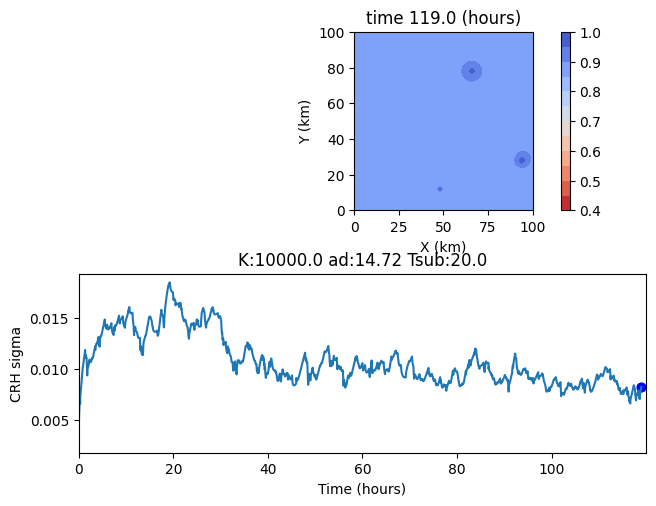

toy_diffusion_2d model of atmosphere
------------
- RUN PARS -
------------
outdir = None
diffK = 10000.0
crh_ad = 14.72
tau_sub = 20.0
diurn_opt = 0
w_cnv = 10.0
tau_cnv = 60.0
crh_det = 1.05
cnv_lifetime = 1800.0
cin_radius = -99
diffCIN = 125000.0
tau_cin = 10800.0
diurn_a = 0.6
diurn_p = 2.0
crh_init_mn = 0.8
crh_init_sd = 0.0
nday = 5
dt = 60.0
domain_xy = 100000.0
dxy = 2000.0
nfig_hr = 1.0
lplot = True
-----------


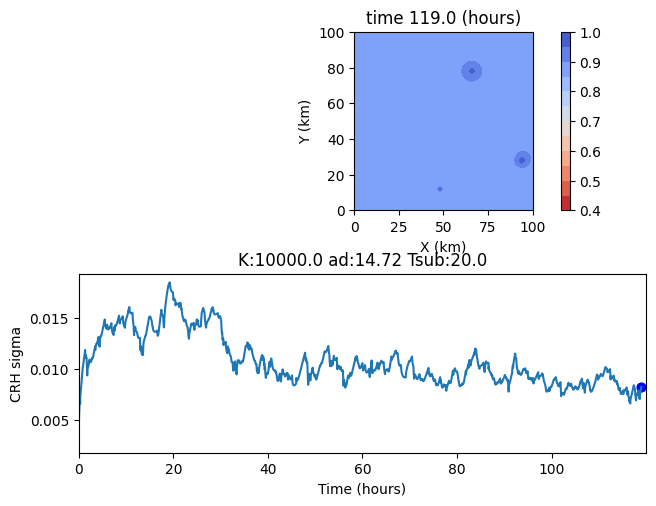

In [6]:

pars=defaults() 
srdm(pars)


## Changing parameters

It is straightforward to change model parameters and rerun the code.  For example the first experiment was with a small 100x100km2 domain. Now let's try a larger domain.  If you forget what the parameters are called just take a look at the variable pars.  Okay, here we go...

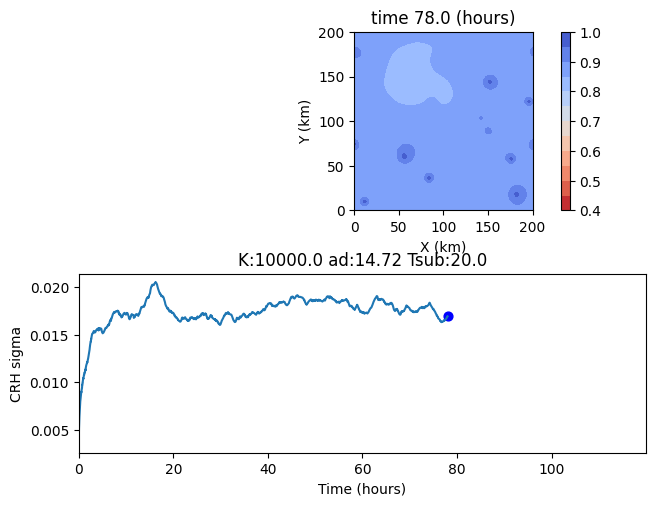

toy_diffusion_2d model of atmosphere
------------
- RUN PARS -
------------
outdir = None
diffK = 10000.0
crh_ad = 14.72
tau_sub = 20.0
diurn_opt = 0
w_cnv = 10.0
tau_cnv = 60.0
crh_det = 1.05
cnv_lifetime = 1800.0
cin_radius = -99
diffCIN = 125000.0
tau_cin = 10800.0
diurn_a = 0.6
diurn_p = 2.0
crh_init_mn = 0.8
crh_init_sd = 0.0
nday = 5
dt = 60.0
domain_xy = 200000.0
dxy = 2000.0
nfig_hr = 1.0
lplot = True
-----------


In [ ]:
pars["domain_xy"]=200.e3
srdm(pars)


## Exercises

### Model Parameters

The main input parameters we will play with today are:

- **diffK** the horizontal moisture transport efficiency $K$, assumed to be the same in both directions. 	Units m$^2$s$^{-1}$, default value $10^4$ m$^2$s$^{-1}$.
- **tau_sub** is  the subsidence drying timescale $\tau_{\text{sub}}$ (in days, not seconds!). Default value $20$ days.
- **crh_ad** is the strength of the moisture-convection feedback, i.e., the steepness $a_d$ of the exponential function governing the choice of convective locations. Default is $14.72$ from TRMM retrieval version 7 
- **crh_init_mn** and **crh_init_sd** are the spatial mean and standard deviation of the initial $R$ field.
- **cnv_lifetime** is the average lifetime of a convective event. Units seconds, default value $1800$ s.
- **nday** and **dt** are the total simulated time (in days) and the model time step (in seconds).
- **domain_xy** and **dxy** are the domain size and horizontal resolution, both in meters.
- **nfig_hr** is the frequency of map slices (one map to be stored into a netcdf file/plotted) 
	
### Questions

- What do you think is happening if we set $a_d = 0$? What does it mean in practice? Do we promote or prevent self-aggregation?
- Equation (17) in the [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022MS003231) predicts that aggregation is more likely at coarser resolutions, or larger domain sizes, or weaker diffusion, or stronger subsidence, or stronger convection-vapour feedback. Can you confirm some of these sensitivities with some experiments?
- What if we change the convective lifetime to 2 hours (7200 $s$)? What do you expect is the impact on aggregation
- What happens if we start with horizontally homogeneous very dry ($R(t=0) = 0.01$) or moist ($R(t=0)=1.05$) conditions?



